<a href="https://colab.research.google.com/github/shuuuuyu/113-3-DSCP/blob/main/%E4%BB%8A%E5%A4%A9%E7%85%AE%E4%BB%80%E9%BA%BC%EF%BC%9FCookNow!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 今天煮什麼？CookNow!

- 動機:
    - 由於家裡買的食物經常放在冰箱放到過期，因此我一直有個想法是可以透過寫一個˙小工具來管理食材，並且以此為發想新增其他功能，像是新增食譜、推薦今天煮甚麼。
- 說明：
    - 這個程式有四個功能，
        - 管理食材:可新增、刪除、查看
        - 管理食譜:可新增、刪除、查看、檢查是否有足夠食材製作
        - 推薦料理:根據現有食材，比對食譜上需要的食材，優先推薦符合所有食材的食譜
        - 食材統計:
            - 分類數量長條圖(冷藏、冷凍、乾貨)
            - 剩餘天數長條圖
            - 保存狀態圓餅圖(已過期、快過期、保存中)
    - 以gradio製作外觀，資料(食材、食譜)存在雲端硬碟，所以若要使用需要您的雲端硬碟授權，我的測試資料由chatgpt生成，並儲存在我的雲端硬碟當中。
        - 食材:https://drive.google.com/file/d/1D4UD7DYS1HP8ikAfb-m5qvzct9E_o-1Q/view?usp=sharing
        - 食譜:https://drive.google.com/file/d/1aN-pHJbeKcZXSwACaqTKyRHw4DWSb3BZ/view?usp=sharing
    - 寫了一個不用線上colab的版本，github連結:https://github.com/shuuuuyu/113-3-DSCP/tree/main
- 心得:
    - 因為我比較習慣用colab，後來又寫了一個不用線上的版本
    - 我覺得這是一個很好玩的經驗，可以不用在意太多規則，做一個有趣的作業。之前有做過找資料分析數據的作業，但我實在不太擅長，找不到有趣的結論，感覺這次好玩多了。另外我有考慮過有沒有辦法架成一個特定的網站，查了資料沒有找到比較合適的作法，所以放棄，也許等我之後學到更多系統架構再來考慮改進。

### flow chart

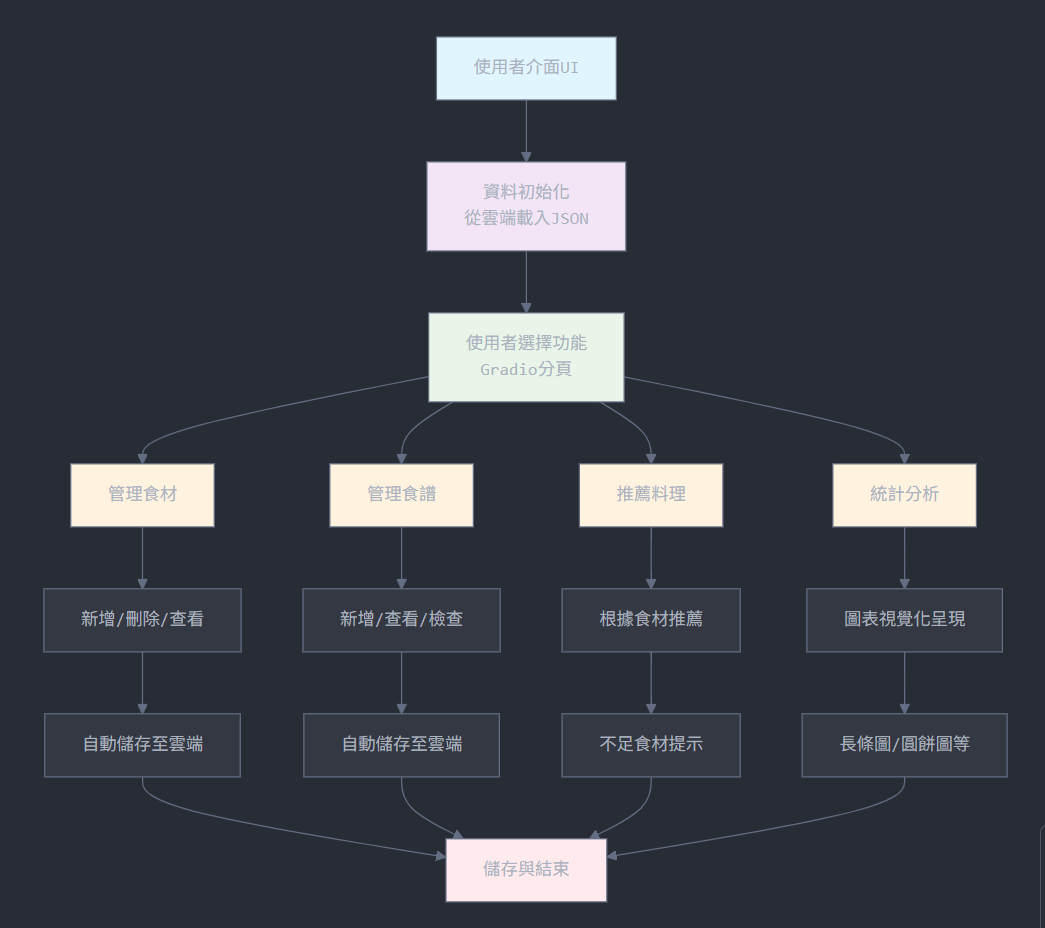

### 成果展示

影片連結:

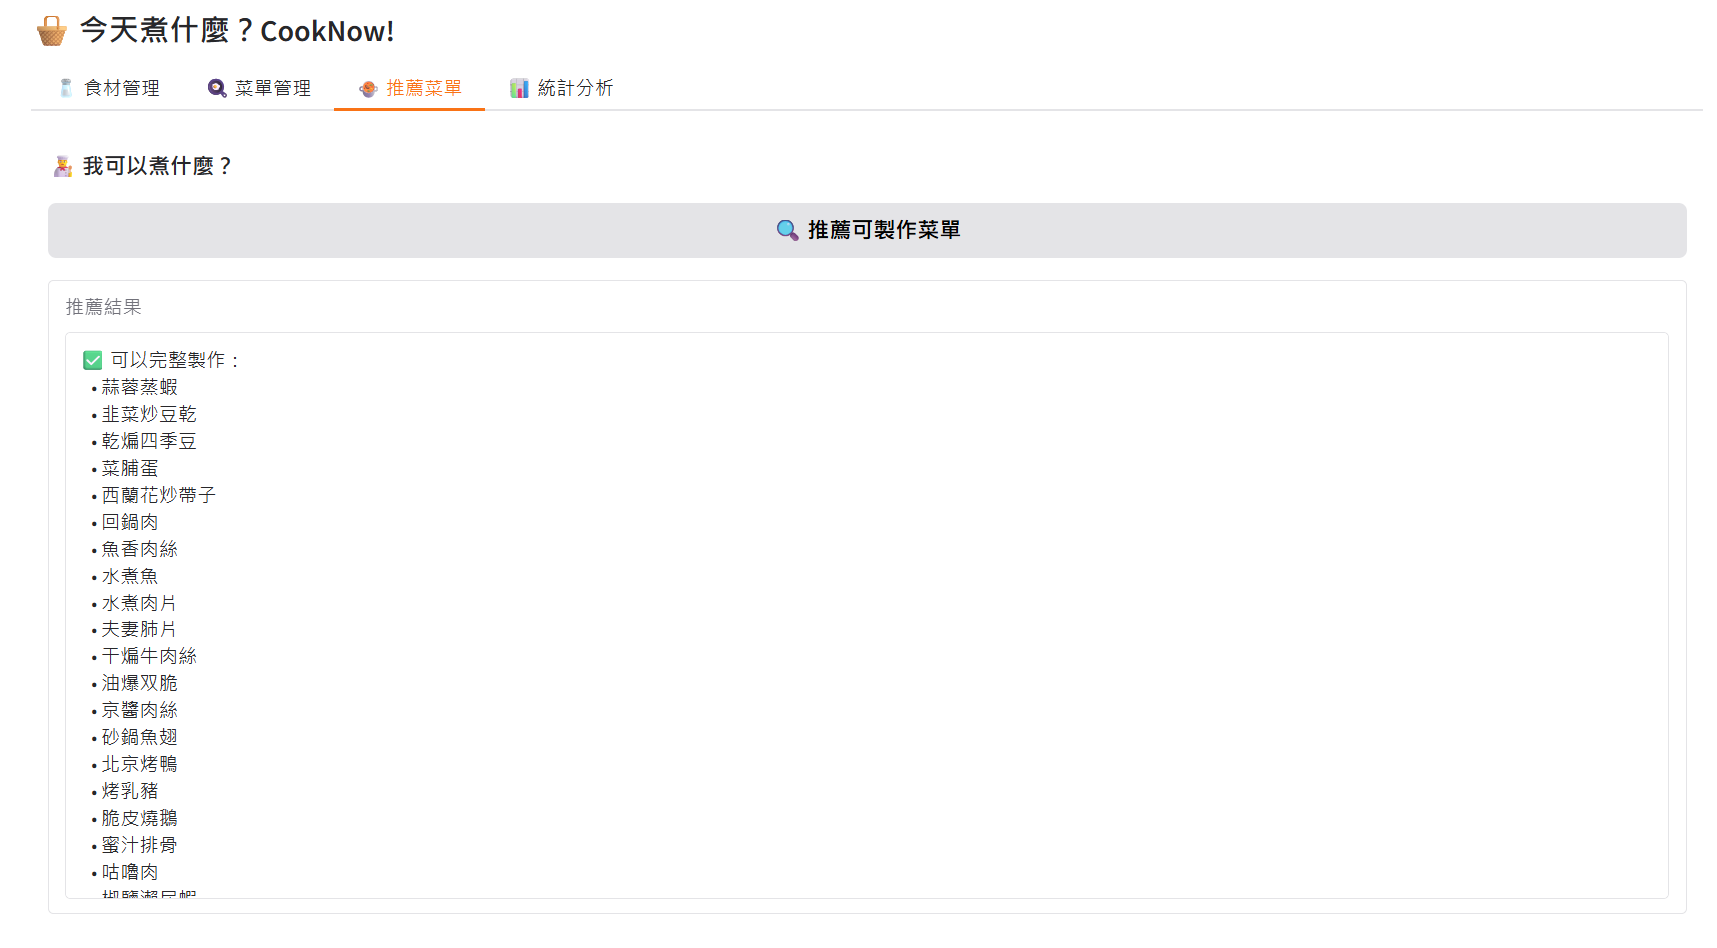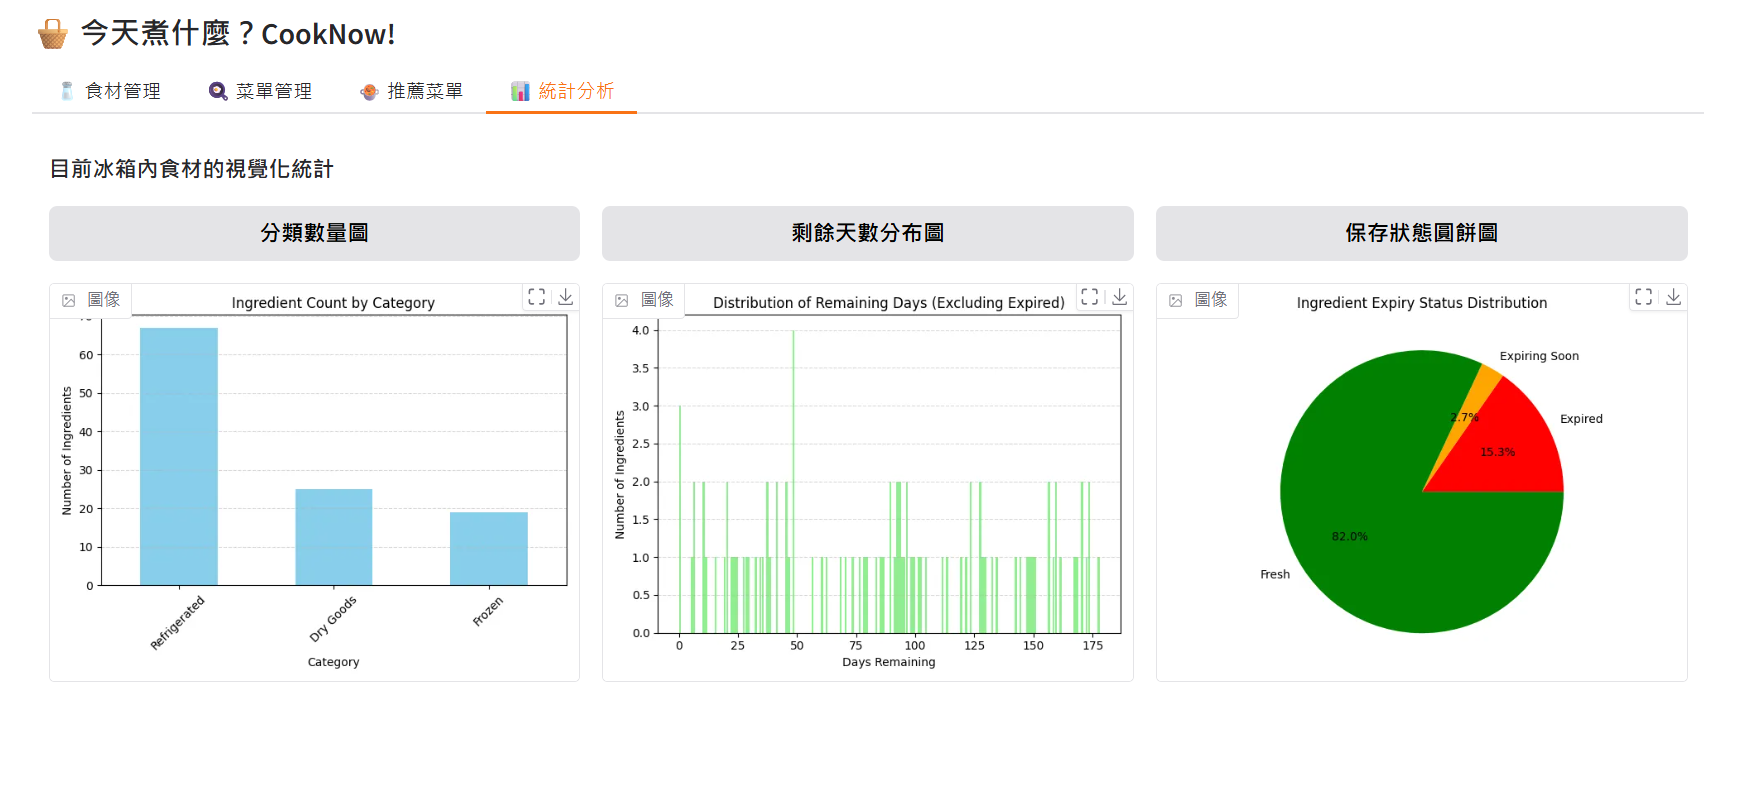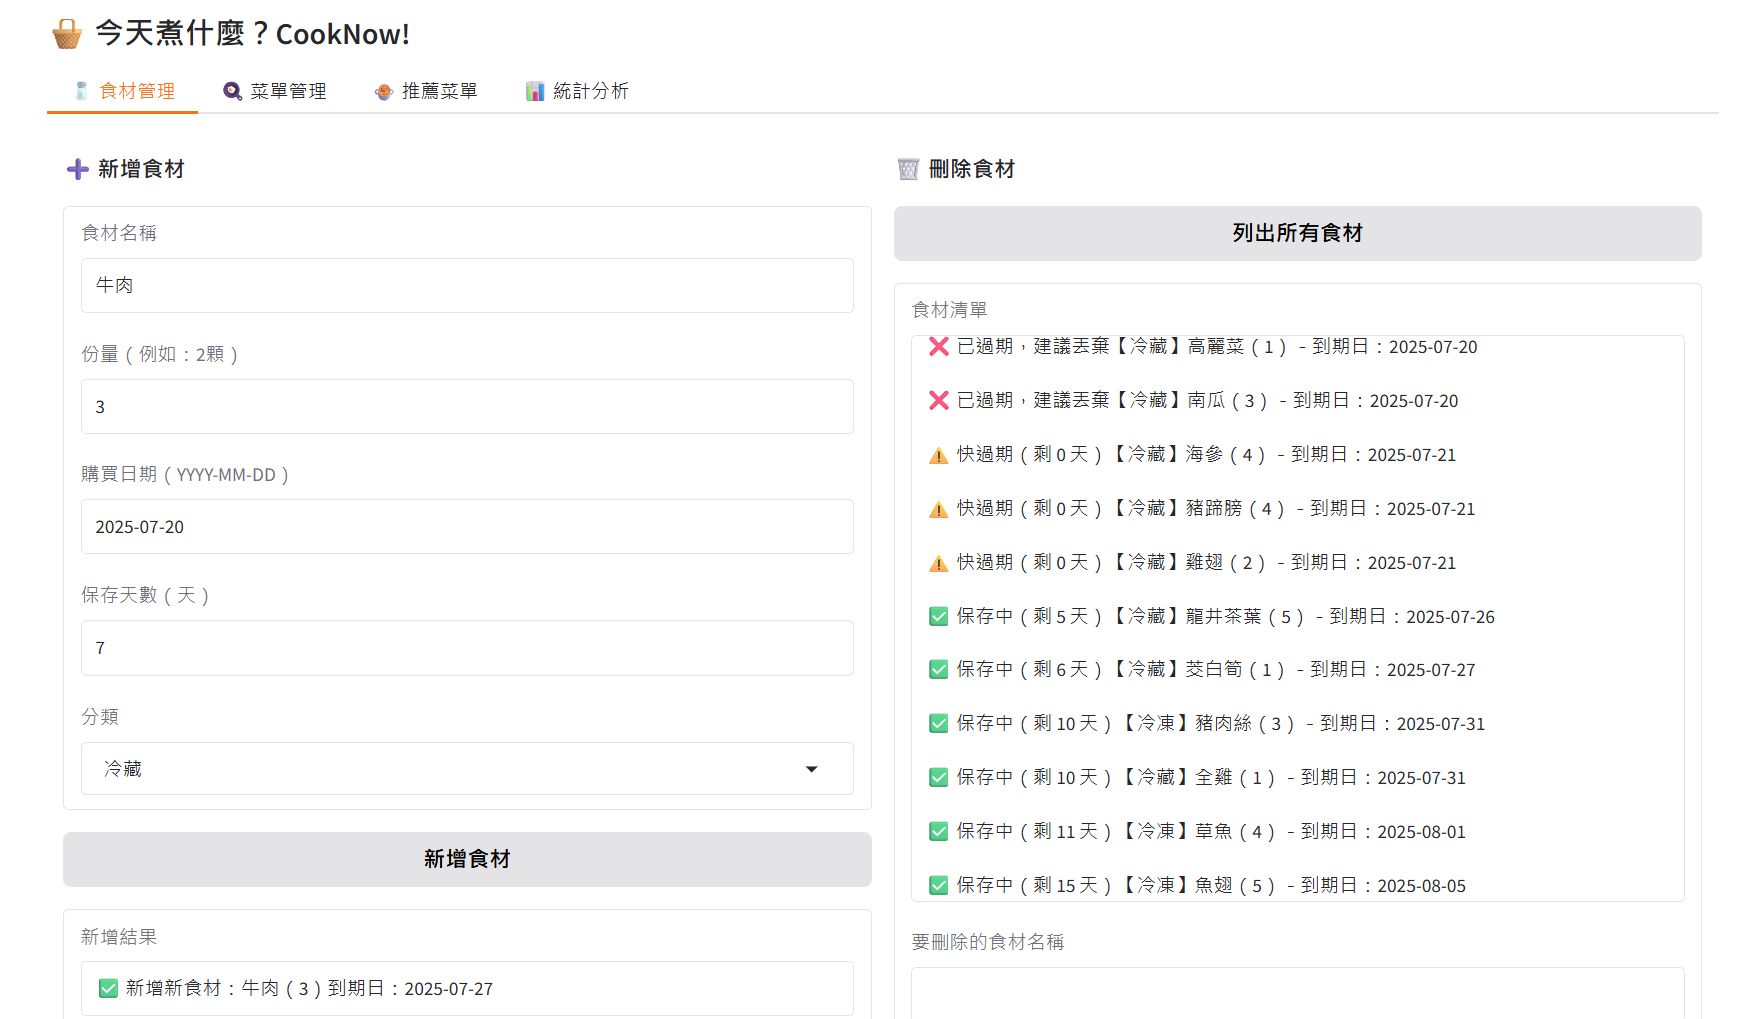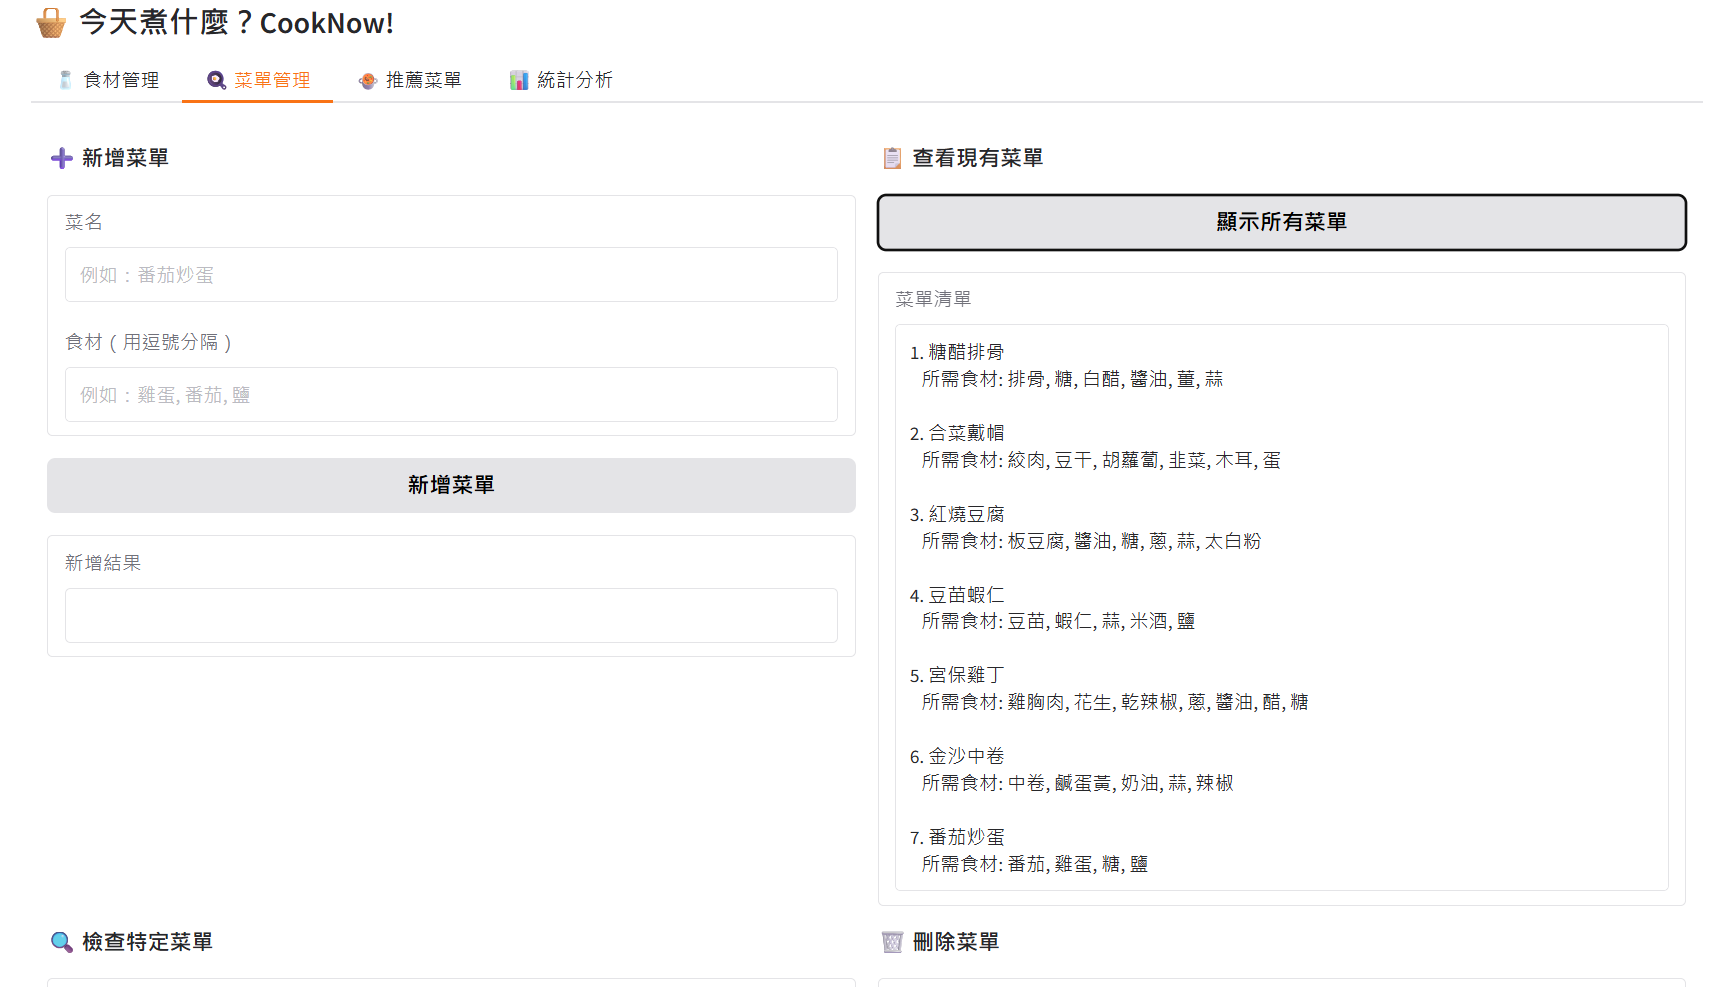

## 程式碼:管理食材與食譜

下載套件

In [1]:
import gradio as gr
from datetime import datetime, timedelta
import os
import json
from google.colab import drive

初始設定

In [2]:
# 1. 掛載 Google 雲端硬碟
drive.mount('/content/drive')

# 2. 建立資料夾與定義檔案路徑
folder_path = "/content/drive/MyDrive/食材管理"
os.makedirs(folder_path, exist_ok=True)

ingredient_file = os.path.join(folder_path, "ingredient_list.json")
menu_file = os.path.join(folder_path, "menu_db.json")

# 3. 定義 Ingredient 類別
class Ingredient:
    def __init__(self, name, quantity, expiry_date, category):
        self.name = name
        self.quantity = quantity
        self.expiry_date = datetime.strptime(expiry_date, "%Y-%m-%d") if isinstance(expiry_date, str) else expiry_date
        self.category = category

    def days_to_expiry(self):
        return (self.expiry_date - datetime.today()).days

    def status(self):
        d = self.days_to_expiry()
        if d < 0:
            return "❌ 已過期，建議丟棄"
        elif d <= 3:
            return f"⚠️ 快過期（剩 {d} 天）"
        else:
            return f"✅ 保存中（剩 {d} 天）"

    def __str__(self):
        return f"{self.status()}【{self.category}】{self.name}（{self.quantity}）－到期日：{self.expiry_date.date()}"

# 4. 定義資料儲存與讀取函式
def save_data():
    try:
        ingredient_data = [{
            "name": i.name,
            "quantity": i.quantity,
            "expiry_date": i.expiry_date.strftime("%Y-%m-%d"),
            "category": i.category
        } for i in ingredient_list]

        with open(ingredient_file, "w", encoding='utf-8') as f:
            json.dump(ingredient_data, f, indent=2, ensure_ascii=False)

        with open(menu_file, "w", encoding='utf-8') as f:
            json.dump(menu_db, f, indent=2, ensure_ascii=False)

        return "✅ 資料已自動儲存"
    except Exception as e:
        return f"❌ 儲存失敗：{e}"

def load_data():
    global ingredient_list, menu_db
    try:
        with open(ingredient_file, "r", encoding='utf-8') as f:
            ingredient_data = json.load(f)
            ingredient_list = [
                Ingredient(
                    name=d["name"],
                    quantity=d["quantity"],
                    expiry_date=d["expiry_date"],
                    category=d["category"]
                ) for d in ingredient_data
            ]
    except FileNotFoundError:
        ingredient_list = []
        print("食材檔案不存在，使用空清單")
    except Exception as e:
        ingredient_list = []
        print(f"讀取食材檔案錯誤：{e}")

    try:
        with open(menu_file, "r", encoding='utf-8') as f:
            menu_db = json.load(f)
    except FileNotFoundError:
        menu_db = []
        print("菜單檔案不存在，使用空清單")
    except Exception as e:
        menu_db = []
        print(f"讀取菜單檔案錯誤：{e}")

    return "✅ 資料載入完成"

# 5. 初始化讀取資料
load_data()


Mounted at /content/drive


'✅ 資料載入完成'

功能1:新增/查詢/刪除食材


In [3]:
def add_ingredient(name, quantity, purchase_date, shelf_life_days, category):
    try:
        # 驗證輸入
        if not name or not quantity or not purchase_date or not shelf_life_days or not category:
            return "❌ 請填寫所有欄位"

        # 轉換購買日期
        purchase_date = datetime.strptime(purchase_date, "%Y-%m-%d")

        # 計算到期日
        expiry_date = purchase_date + timedelta(days=int(shelf_life_days))

        # 檢查是否已有同名食材
        for item in ingredient_list:
            if item.name == name:
                return f"⚠️ 食材 {name} 已存在。如需更新，請先刪除舊的再新增。"

        # 新增新項目
        new_ingredient = Ingredient(name, quantity, expiry_date, category)
        ingredient_list.append(new_ingredient)
        save_data()
        return f"✅ 新增新食材：{name}（{quantity}）到期日：{expiry_date.date()}"

    except ValueError as e:
        return f"❌ 日期格式錯誤，請使用 YYYY-MM-DD 格式"
    except Exception as e:
        return f"❌ 發生錯誤：{str(e)}"

def show_ingredients():
    if not ingredient_list:
        return "目前無食材資料。"

    sorted_list = sorted(ingredient_list, key=lambda x: x.days_to_expiry())
    return "\n\n".join(str(i) for i in sorted_list)

def delete_ingredient_complete(name_to_delete):
    """完整刪除食材"""
    if not name_to_delete:
        return "❌ 請輸入食材名稱"

    for i, item in enumerate(ingredient_list):
        if item.name == name_to_delete:
            ingredient_list.pop(i)
            save_data()
            return f"✅ 已刪除食材：{name_to_delete}"

    return "❌ 找不到該食材"

功能2:新增/查詢/刪除食譜

In [4]:
def recommend_menu():
    if not ingredient_list:
        return "❗ 沒有食材，請先新增一些喔～"

    # 取目前有的食材名稱（未過期）
    available = [i.name for i in ingredient_list if i.days_to_expiry() >= 0]

    # 計算每道菜的匹配度
    recipe_matches = []
    for recipe in menu_db:
        required = recipe["ingredients"]
        matched = [item for item in required if item in available]
        missing = [item for item in required if item not in available]

        match_rate = len(matched) / len(required) if required else 0

        recipe_matches.append({
            "name": recipe["name"],
            "match_rate": match_rate,
            "matched_count": len(matched),
            "total_count": len(required),
            "missing": missing
        })

    # 按匹配度排序
    recipe_matches.sort(key=lambda x: x["match_rate"], reverse=True)

    if not recipe_matches:
        return "😢 目前沒有菜單資料"

    # 組織輸出
    result = []

    # 100% 匹配的菜
    complete_matches = [r for r in recipe_matches if r["match_rate"] == 1.0]
    if complete_matches:
        result.append("✅ 可以完整製作：")
        for recipe in complete_matches:
            result.append(f"   • {recipe['name']}")

    # 部分匹配的菜（50% 以上）
    partial_matches = [r for r in recipe_matches if 0.5 <= r["match_rate"] < 1.0]
    if partial_matches:
        result.append("\n⚠️ 可考慮製作：")
        for recipe in partial_matches:
            percentage = int(recipe["match_rate"] * 100)
            missing_str = "、".join(recipe["missing"])
            result.append(f"   • {recipe['name']} ({percentage}%，缺：{missing_str})")

    # 低匹配度的菜（顯示前3個）
    low_matches = [r for r in recipe_matches if r["match_rate"] < 0.5][:3]
    if low_matches and not complete_matches and not partial_matches:
        result.append("\n❌ 食材不足，但可參考：")
        for recipe in low_matches:
            percentage = int(recipe["match_rate"] * 100)
            missing_str = "、".join(recipe["missing"])
            result.append(f"   • {recipe['name']} ({percentage}%，缺：{missing_str})")

    return "\n".join(result) if result else "😢 目前食材不足，無法製作資料庫裡的菜色。"

def check_menu_ingredients(menu_name):
    matched = [m for m in menu_db if m["name"] == menu_name]
    if not matched:
        return "❌ 找不到這道菜"

    required = matched[0]["ingredients"]
    have = [i.name for i in ingredient_list if i.days_to_expiry() >= 0]
    missing = [item for item in required if item not in have]

    if not missing:
        return f"✅ 你有所有食材，可以做「{menu_name}」！"
    else:
        return f"⚠️ 缺少食材：{', '.join(missing)}"

def get_menu_names():
    choices = [m["name"] for m in menu_db]
    return choices, choices  # 回傳兩個相同的清單給兩個 dropdown

def show_all_menus():
    if not menu_db:
        return "目前沒有菜單資料"

    result = []
    for i, menu in enumerate(menu_db, 1):
        ingredients = ", ".join(menu["ingredients"])
        result.append(f"{i}. {menu['name']}\n   所需食材: {ingredients}")

    return "\n\n".join(result)

def delete_menu(menu_name):
    if not menu_name:
        return "❌ 請選擇要刪除的菜單"

    for i, menu in enumerate(menu_db):
        if menu["name"] == menu_name:
            menu_db.pop(i)
            save_data()
            return f"✅ 已刪除菜單：{menu_name}"

    return "❌ 找不到該菜單"

def add_recipe(dish_name, ingredients_text):
    if not dish_name or not ingredients_text:
        return "❌ 請輸入菜名與至少一個食材"

    ingredients_list = [item.strip() for item in ingredients_text.split(",") if item.strip()]

    if not ingredients_list:
        return "❌ 食材格式錯誤，請用逗號分隔"

    menu_db.append({
        "name": dish_name,
        "ingredients": ingredients_list
    })
    save_data()
    return f"✅ 成功新增菜單：{dish_name}（所需食材：{', '.join(ingredients_list)}）"


## 程式碼:資料視覺化

下載套件

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import io
from PIL import Image

食材分類長條圖

In [6]:
def plot_category_bar_gradio():
    # 分類中文 -> 英文對照
    category_mapping = {
        "冷藏": "Refrigerated",
        "冷凍": "Frozen",
        "乾貨": "Dry Goods"
    }

    # 原始分類資料
    categories = [category_mapping.get(i.category, i.category) for i in ingredient_list]
    df = pd.Series(categories).value_counts()

    fig, ax = plt.subplots()
    df.plot(kind='bar', color='skyblue', ax=ax)
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df.index, rotation=45)
    ax.set_title("Ingredient Count by Category")
    ax.set_xlabel("Category")
    ax.set_ylabel("Number of Ingredients")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)


食材剩餘天數分布圖（柱狀圖）

In [7]:
def plot_remaining_days_gradio():
    days = [i.days_to_expiry() for i in ingredient_list if i.days_to_expiry() >= 0]
    df = pd.Series(days)

    fig, ax = plt.subplots()
    df.plot(kind='hist', bins=range(0, max(days)+2), rwidth=0.9, color='lightgreen', ax=ax)
    ax.set_title("Distribution of Remaining Days (Excluding Expired)")
    ax.set_xlabel("Days Remaining")
    ax.set_ylabel("Number of Ingredients")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

食材狀態圓餅圖（保存中 vs 快過期 vs 已過期）

In [8]:
def plot_expiry_status_pie_gradio():
    expired = 0
    warning = 0
    ok = 0

    for i in ingredient_list:
        d = i.days_to_expiry()
        if d < 0:
            expired += 1
        elif d <= 3:
            warning += 1
        else:
            ok += 1

    labels = ["Expired", "Expiring Soon", "Fresh"]
    values = [expired, warning, ok]
    colors = ['red', 'orange', 'green']

    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, autopct="%1.1f%%", colors=colors)
    ax.set_title("Ingredient Expiry Status Distribution")
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)


## 建立外觀

In [10]:
with gr.Blocks() as demo:
    gr.Markdown("## 🧺 今天煮什麼？CookNow!")

    with gr.Tabs():
        with gr.Tab("🧂 食材管理"):
            with gr.Row():
                with gr.Column():
                    gr.Markdown("### ➕ 新增食材")
                    name = gr.Textbox(label="食材名稱", placeholder="例如：雞蛋")
                    quantity = gr.Textbox(label="份量（例如：2顆）", placeholder="例如：2")
                    purchase_date = gr.Textbox(label="購買日期（YYYY-MM-DD）", placeholder="例如：2024-01-15")
                    shelf_life_days = gr.Number(label="保存天數（天）", precision=0, value=7)
                    category = gr.Dropdown(label="分類", choices=["冷藏", "冷凍", "乾貨"], value="冷藏")
                    add_btn = gr.Button("新增食材")
                    add_output = gr.Textbox(label="新增結果")
                    add_btn.click(fn=add_ingredient, inputs=[name, quantity, purchase_date, shelf_life_days, category], outputs=add_output)

                with gr.Column():
                    gr.Markdown("### 🗑️ 刪除食材")
                    query_btn = gr.Button("列出所有食材")
                    query_output = gr.Textbox(lines=8, label="食材清單")
                    query_btn.click(fn=show_ingredients, outputs=query_output)

                    delete_name = gr.Textbox(label="要刪除的食材名稱")
                    delete_btn = gr.Button("完全刪除食材", variant="secondary")
                    delete_result = gr.Textbox(label="刪除結果")

                    delete_btn.click(fn=delete_ingredient_complete,
                                    inputs=[delete_name],
                                    outputs=delete_result)

        with gr.Tab("🍳 菜單管理"):
            with gr.Row():
                with gr.Column():
                    gr.Markdown("### ➕ 新增菜單")
                    dish_input = gr.Textbox(label="菜名", placeholder="例如：番茄炒蛋")
                    ingredient_input = gr.Textbox(label="食材（用逗號分隔）", placeholder="例如：雞蛋, 番茄, 鹽")
                    add_recipe_btn = gr.Button("新增菜單")
                    add_recipe_output = gr.Textbox(label="新增結果")
                    add_recipe_btn.click(fn=add_recipe, inputs=[dish_input, ingredient_input], outputs=add_recipe_output)

                with gr.Column():
                    gr.Markdown("### 📋 查看現有菜單")
                    show_menu_btn = gr.Button("顯示所有菜單")
                    menu_list_output = gr.Textbox(label="菜單清單", lines=8)
                    show_menu_btn.click(fn=show_all_menus, outputs=menu_list_output)

            with gr.Row():
                with gr.Column():
                    gr.Markdown("### 🔍 檢查特定菜單")
                    menu_choices = gr.Dropdown(label="選擇菜單", choices=[m["name"] for m in menu_db])
                    check_btn = gr.Button("檢查是否能製作")
                    check_output = gr.Textbox(label="檢查結果")
                    check_btn.click(fn=check_menu_ingredients, inputs=menu_choices, outputs=check_output)

                with gr.Column():
                    gr.Markdown("### 🗑️ 刪除菜單")
                    delete_menu_dropdown = gr.Dropdown(label="選擇要刪除的菜單", choices=[m["name"] for m in menu_db])
                    delete_menu_btn = gr.Button("刪除菜單", variant="secondary")
                    delete_menu_output = gr.Textbox(label="刪除結果")
                    delete_menu_btn.click(fn=delete_menu, inputs=delete_menu_dropdown, outputs=delete_menu_output)

            with gr.Row():
                reload_btn = gr.Button("🔄 重新載入菜單清單")
                reload_btn.click(fn=get_menu_names, outputs=[menu_choices, delete_menu_dropdown])

        with gr.Tab("🍲 推薦菜單"):
            gr.Markdown("### 👨‍🍳 我可以煮什麼？")
            menu_btn = gr.Button("🔍 推薦可製作菜單")
            menu_output = gr.Textbox(label="推薦結果", lines=10)
            menu_btn.click(fn=recommend_menu, outputs=menu_output)

        with gr.Tab("📊 統計分析"):
            gr.Markdown("### 目前冰箱內食材的視覺化統計")
            with gr.Row():
                with gr.Column():
                    bar_btn = gr.Button("分類數量圖")
                    bar_img = gr.Image()
                    bar_btn.click(fn=plot_category_bar_gradio, outputs=bar_img)

                with gr.Column():
                    hist_btn = gr.Button("剩餘天數分布圖")
                    hist_img = gr.Image()
                    hist_btn.click(fn=plot_remaining_days_gradio, outputs=hist_img)

                with gr.Column():
                    pie_btn = gr.Button("保存狀態圓餅圖")
                    pie_img = gr.Image()
                    pie_btn.click(fn=plot_expiry_status_pie_gradio, outputs=pie_img)



demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8913d2373982678afa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
